# EDA for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

In [193]:
# 데이터 경로
path = "C:/Users/aryij/Documents/DataStudy/DAStudy-sat/Tek/football-data-from-transfermarkt/data/df_preprocessed.csv"
df = pd.read_csv(path)

In [194]:
df.head()

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0   Aaron Connolly          2019             0          0      3        2   
1   Aaron Connolly          2020             0          0      2        1   
2   Aaron Connolly          2021             0          0      0        0   
3  Aaron Cresswell          2019             7          0      3        0   
4  Aaron Cresswell          2020             3          0      0        8   

   minutes_played  total_apps competition_code date_of_birth        position  \
0            1261          24   premier-league    2000-01-28  Centre-Forward   
1             791          17   premier-league    2000-01-28  Centre-Forward   
2             155           4   premier-league    2000-01-28  Centre-Forward   
3            2730          31   premier-league    1989-12-15       Left-Back   
4            3172          36   premier-league    1989-12-15       Left-Back   

                        current_club_name  highest_market_value  \
0  Brighton and Hove Albion Football Club             7000000.0   
1  Brighton and Hove Albion Football Club             7000000.0   
2  Brighton and Hove Albion Football Club             7000000.0   
3           West Ham United Football Club            12000000.0   
4           West Ham United Football Club            12000000.0   

   market_value_per_season  country   foot  height_in_cm  
0                4000000.0  Ireland  right         174.0  
1                7000000.0  Ireland  right         174.0  
2                6000000.0  Ireland  right         174.0  
3                6500000.0  England   left         170.0  
4                5000000.0  England   left         170.0

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   yellow_cards             16001 non-null  int64  
 3   red_cards                16001 non-null  int64  
 4   goals                    16001 non-null  int64  
 5   assists                  16001 non-null  int64  
 6   minutes_played           16001 non-null  int64  
 7   total_apps               16001 non-null  int64  
 8   competition_code         16001 non-null  object 
 9   date_of_birth            16001 non-null  object 
 10  position                 16001 non-null  object 
 11  current_club_name        16001 non-null  object 
 12  highest_market_value     16001 non-null  float64
 13  market_value_per_season  16001 non-null  float64
 14  country               

In [196]:
# date_of_birth 컬럼 타입 datetime으로 변경
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], format='%Y-%m-%d')

# start_season 컬럼 타입 object로 변경
# df["start_season"] = df["start_season"].astype(str)

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   player_name              16001 non-null  object        
 1   start_season             16001 non-null  int64         
 2   yellow_cards             16001 non-null  int64         
 3   red_cards                16001 non-null  int64         
 4   goals                    16001 non-null  int64         
 5   assists                  16001 non-null  int64         
 6   minutes_played           16001 non-null  int64         
 7   total_apps               16001 non-null  int64         
 8   competition_code         16001 non-null  object        
 9   date_of_birth            16001 non-null  datetime64[ns]
 10  position                 16001 non-null  object        
 11  current_club_name        16001 non-null  object        
 12  highest_market_value     16001 n

### `.describe()` 확인

In [198]:
df.describe()

start_season  yellow_cards     red_cards         goals       assists  \
count  16001.000000  16001.000000  16001.000000  16001.000000  16001.000000   
mean    2020.966127      2.655397      0.070371      1.649772      1.281982   
min     2019.000000      0.000000      0.000000      0.000000      0.000000   
25%     2020.000000      0.000000      0.000000      0.000000      0.000000   
50%     2021.000000      2.000000      0.000000      0.000000      0.000000   
75%     2022.000000      4.000000      0.000000      2.000000      2.000000   
max     2023.000000     18.000000      3.000000     41.000000     22.000000   
std        1.395789      2.683233      0.271657      3.095151      2.062306   

       minutes_played    total_apps                  date_of_birth  \
count    16001.000000  16001.000000                          16001   
mean      1213.143491     18.343479  1995-09-16 11:28:59.816261504   
min          1.000000      1.000000            1977-09-13 00:00:00   
25%        360.000000      9.000000            1992-06-18 00:00:00   
50%       1103.000000     19.000000            1996-01-24 00:00:00   
75%       1933.000000     27.000000            1999-03-01 00:00:00   
max       3420.000000     39.000000            2007-10-02 00:00:00   
std        924.900697     10.842913                            NaN   

       highest_market_value  market_value_per_season  height_in_cm  
count          1.600100e+04             1.600100e+04  16001.000000  
mean           1.654632e+07             9.289160e+06    182.504093  
min            5.000000e+04             2.500000e+04    162.000000  
25%            3.000000e+06             1.200000e+06    178.000000  
50%            9.000000e+06             3.500000e+06    183.000000  
75%            2.200000e+07             1.100000e+07    187.000000  
max            2.000000e+08             1.800000e+08    206.000000  
std            2.153660e+07             1.468148e+07      6.627018

In [199]:
df.describe(include="object")

player_name competition_code     position  \
count        16001            16001        16001   
unique        6062                6           13   
top     João Pedro          serie-a  Centre-Back   
freq            19             3003         2902   

                     current_club_name country   foot  
count                            16001   16001  16001  
unique                             281     126      3  
top     Newcastle United Football Club   Spain  right  
freq                               163    1998  11368

### 분포 확인

In [200]:
df

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0       Aaron Connolly          2019             0          0      3        2   
1       Aaron Connolly          2020             0          0      2        1   
2       Aaron Connolly          2021             0          0      0        0   
3      Aaron Cresswell          2019             7          0      3        0   
4      Aaron Cresswell          2020             3          0      0        8   
...                ...           ...           ...        ...    ...      ...   
15996   İlkay Gündoğan          2019             7          0      2        1   
15997   İlkay Gündoğan          2020             1          0     13        3   
15998   İlkay Gündoğan          2021             1          0      8        3   
15999   İlkay Gündoğan          2022             0          0      8        5   
16000   İlkay Gündoğan          2023             3          0      5        6   

       minutes_played  total_apps competition_code date_of_birth  \
0                1261          24   premier-league    2000-01-28   
1                 791          17   premier-league    2000-01-28   
2                 155           4   premier-league    2000-01-28   
3                2730          31   premier-league    1989-12-15   
4                3172          36   premier-league    1989-12-15   
...               ...         ...              ...           ...   
15996            2017          31   premier-league    1990-10-24   
15997            2031          28   premier-league    1990-10-24   
15998            1855          27   premier-league    1990-10-24   
15999            2359          31   premier-league    1990-10-24   
16000            2278          28           laliga    1990-10-24   

               position                       current_club_name  \
0        Centre-Forward  Brighton and Hove Albion Football Club   
1        Centre-Forward  Brighton and Hove Albion Football Club   
2        Centre-Forward  Brighton and Hove Albion Football Club   
3             Left-Back           West Ham United Football Club   
4             Left-Back           West Ham United Football Club   
...                 ...                                     ...   
15996  Central Midfield                   Futbol Club Barcelona   
15997  Central Midfield                   Futbol Club Barcelona   
15998  Central Midfield                   Futbol Club Barcelona   
15999  Central Midfield                   Futbol Club Barcelona   
16000  Central Midfield                   Futbol Club Barcelona   

       highest_market_value  market_value_per_season  country   foot  \
0                 7000000.0                4000000.0  Ireland  right   
1                 7000000.0                7000000.0  Ireland  right   
2                 7000000.0                6000000.0  Ireland  right   
3                12000000.0                6500000.0  England   left   
4                12000000.0                5000000.0  England   left   
...                     ...                      ...      ...    ...   
15996            50000000.0               40000000.0  Germany  right   
15997            50000000.0               40000000.0  Germany  right   
15998            50000000.0               25000000.0  Germany  right   
15999            50000000.0               20000000.0  Germany  right   
16000            50000000.0               18000000.0  Germany  right   

       height_in_cm  
0             174.0  
1             174.0  
2             174.0  
3             170.0  
4             170.0  
...             ...  
15996         180.0  
15997         180.0  
15998         180.0  
15999         180.0  
16000         180.0  

[16001 rows x 17 columns]

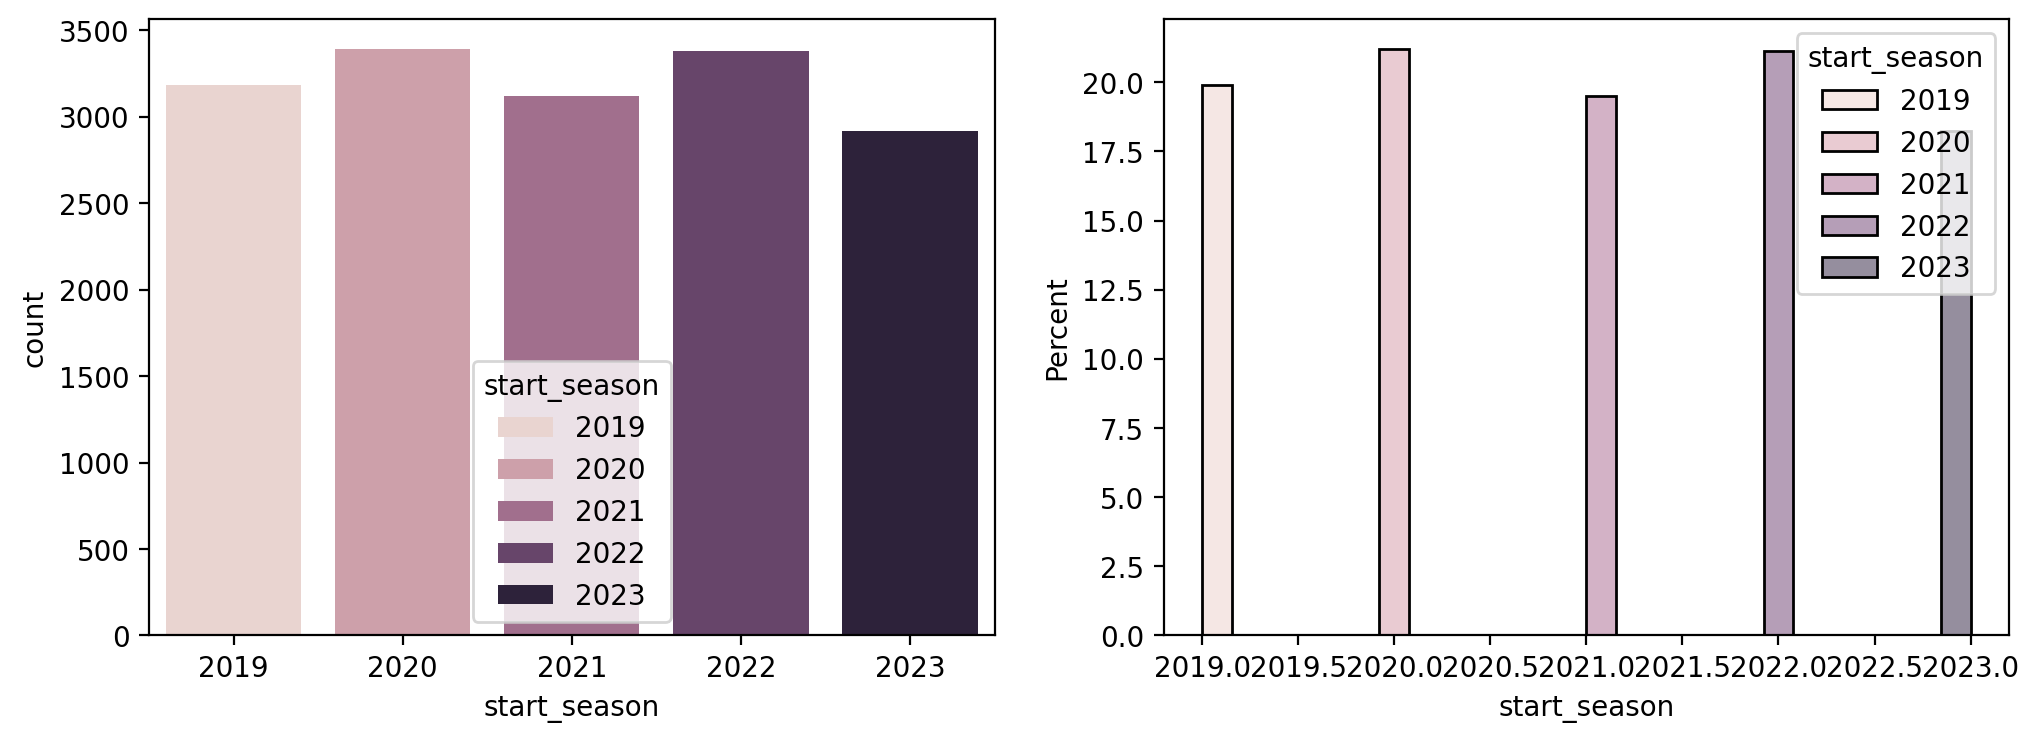

In [201]:
# season별 데이터 숫자 분포 확인
# 숫자 count, 비율도 함께 확인

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

g1 = sns.countplot(data=df, x="start_season", hue="start_season", ax=axes[0])
g2 = sns.histplot(data=df, x="start_season", hue="start_season", stat="percent", ax=axes[1])


## 이상치 확인
- `boxplot` 그려서 확인

In [202]:
# num_cols = df.select_dtypes(include="number").columns.drop("last_season").tolist()
num_cols = df.select_dtypes(include="number").columns.tolist()

print(num_cols)
print(len(num_cols))

['start_season', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'total_apps', 'highest_market_value', 'market_value_per_season', 'height_in_cm']
10


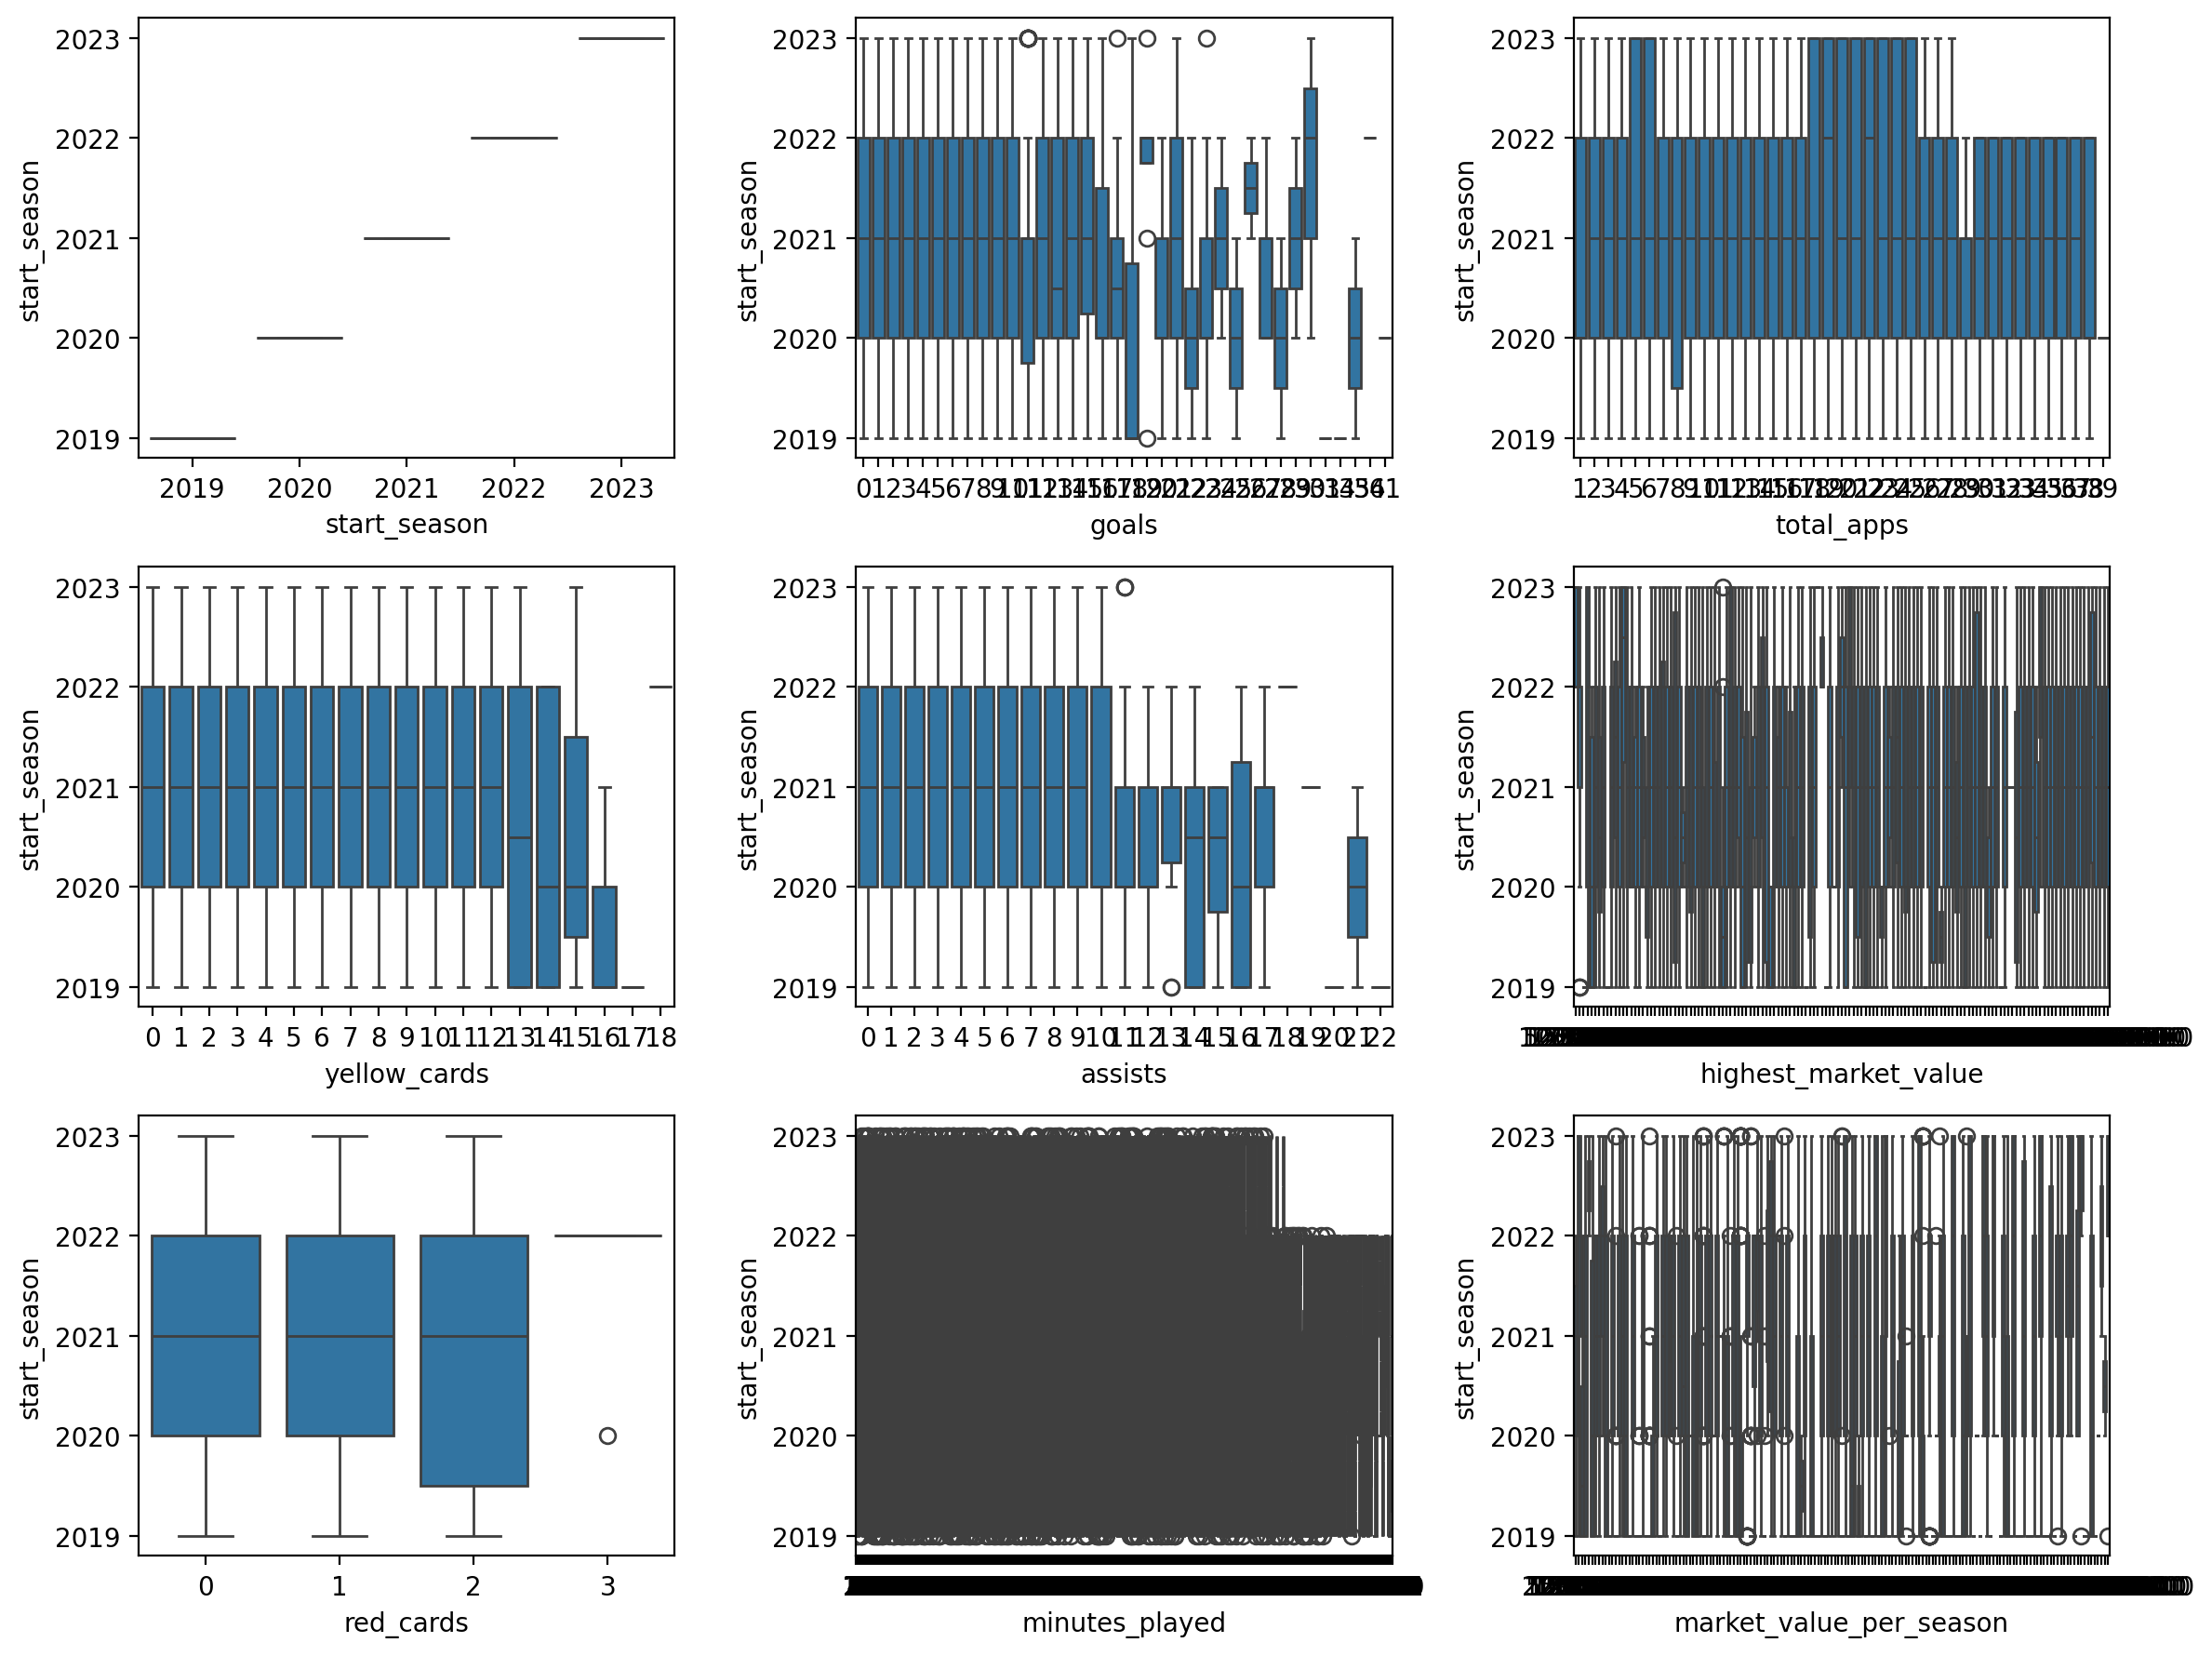

In [203]:
# subplot 생성
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 9))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.boxplot(data=df, x=col, ax=ax, y="start_season")
    # sns.stripplot(data=df, x=col, ax=ax, y="last_season", hue="foot")

fig.tight_layout()
plt.show()

### 이상치 확인 결과
- 전반적으로 `start_season`에 따라 비슷한 결과

- `goals`, `assists`, `market_value` 등 다양한 곳에서 이상치 존재
    - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
- 결론 : 이상치 따로 처리하지 않음

## 상관관계 확인

In [204]:
df_corr = df[num_cols].corr()

df_corr.style.background_gradient()

<Axes: >

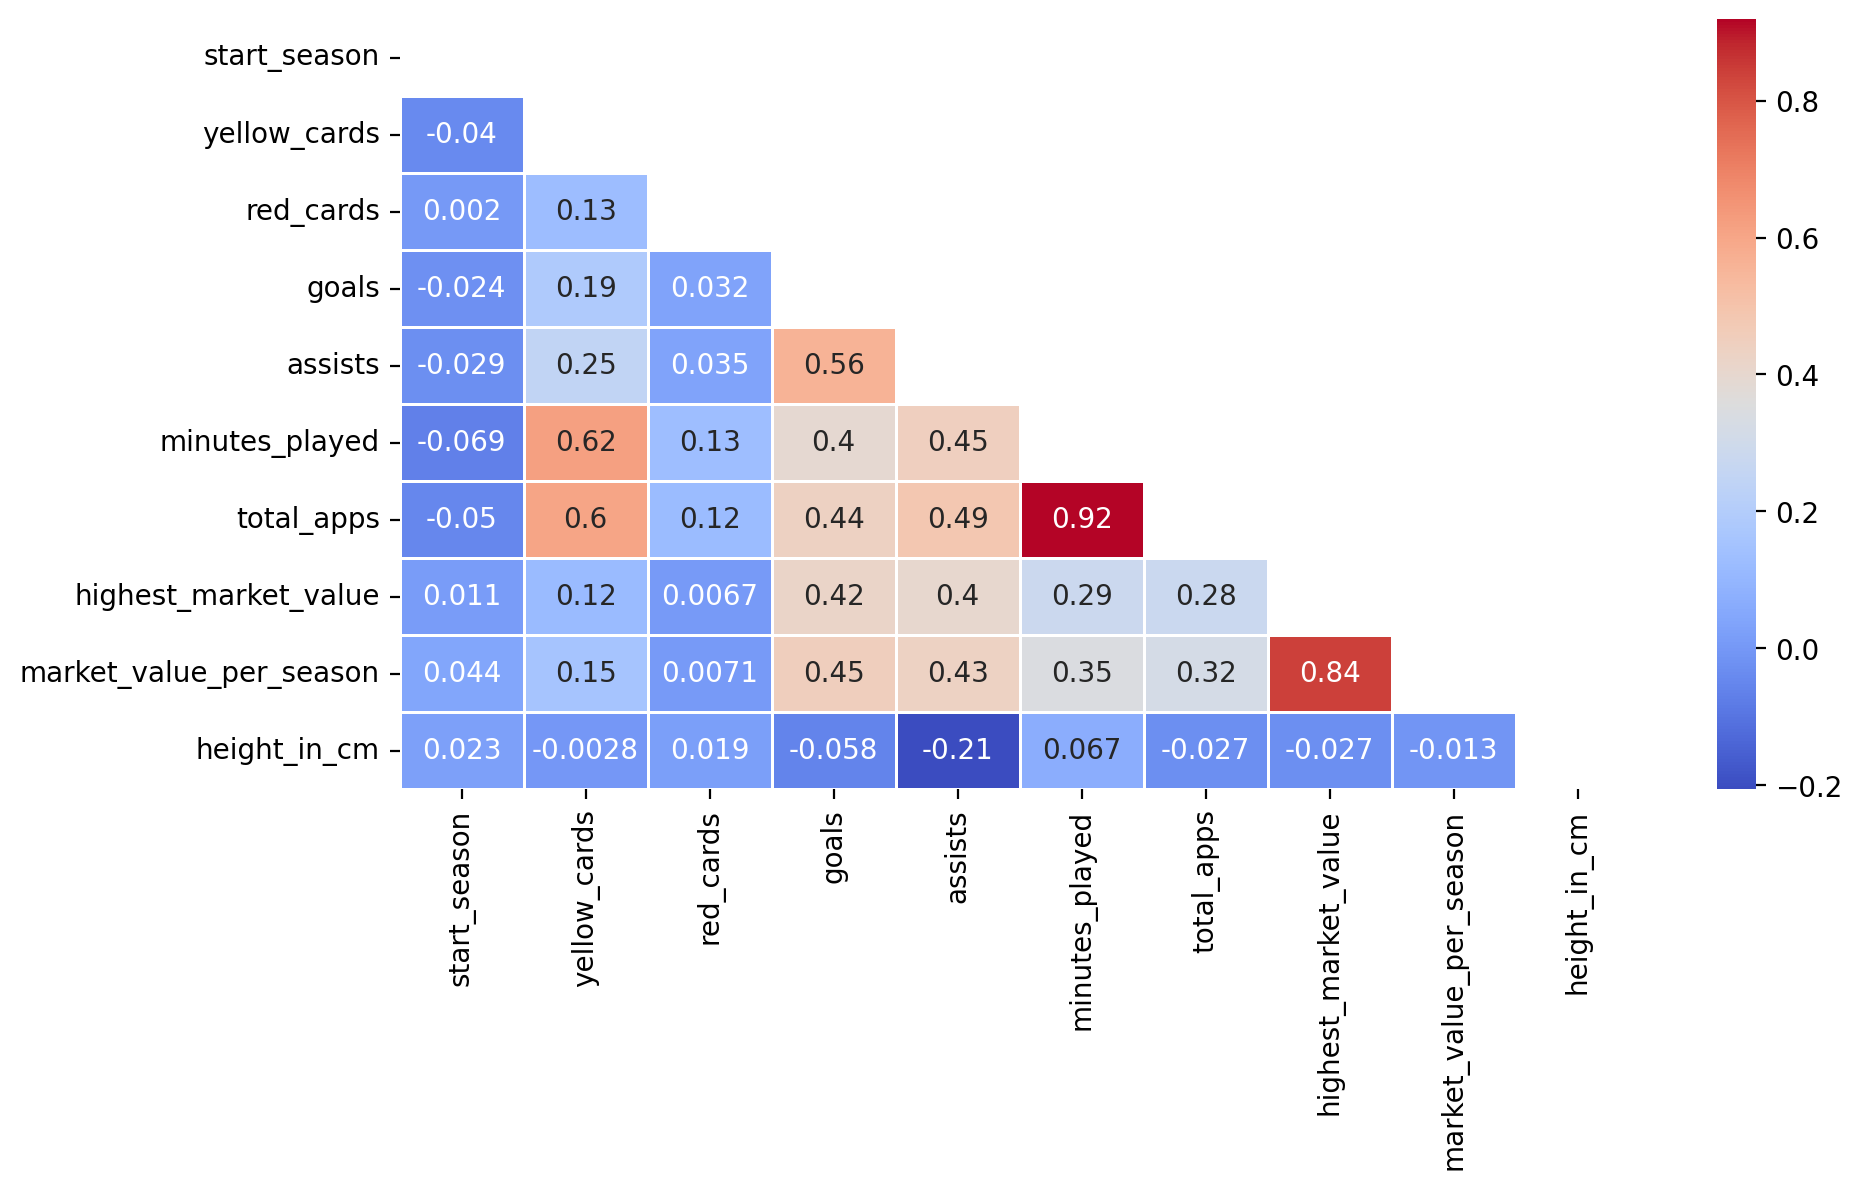

In [205]:
plt.figure(figsize=(10,5))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

### 상관관계 결과
- 매우 강한 상관관계 (0.8 이상)
    - `minutes_played` - `total_apps`
    - `highest_market_value` - `market_value_per_season`
- 강한 상관관계 (0.6 ~ 0.8)
    - `yellow_cards` - `minutes_played`
    - `yellow_cards` - `total_apps`
- 뚜렷한 상관관계 (0.4 ~ 0.6)
    - `goals` - `market_value_per_season`
    - `goals` - `highest_market_value`
    - `goals` - `total_apps`
    - `goals` - `minutes_played`
    - `goals` - `assists`
    - `assists` - `market_value_per_season`
    - `assists` - `highest_market_value`
    - `assists` - `total_apps`
    - `assists` - `minutes_played`
- 약한 상관관계 (0.2 ~ 0.4)
    - `market_value_per_season` - `minutes_played`
    - `market_value_per_season` - `total_apps`
- 음의 상관관계 (-0.2 ~)
    - `assists` - `height_in_cm`

#### 상관관계 높은 변수들 분포 확인
- 상관관계가 높은 변수 관계 4가지 분포 시각화해본다

    - 매우 강한 상관관계 (0.8 이상)
        - `minutes_played` - `total_apps`
        - `highest_market_value` - `market_value_per_season`
    - 강한 상관관계 (0.6 ~ 0.8)
        - `yellow_cards` - `minutes_played`
    - 뚜렷한 상관관계 (0.4 ~ 0.6)
        - `goals` - `market_value_per_season`

In [206]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = {"minutes_played" : "total_apps", 
             "highest_market_value" : "market_value_per_season",
             "yellow_cards" : "minutes_played", 
             "goals" : "market_value_per_season"}
high_corr

{'minutes_played': 'total_apps',
 'highest_market_value': 'market_value_per_season',
 'yellow_cards': 'minutes_played',
 'goals': 'market_value_per_season'}

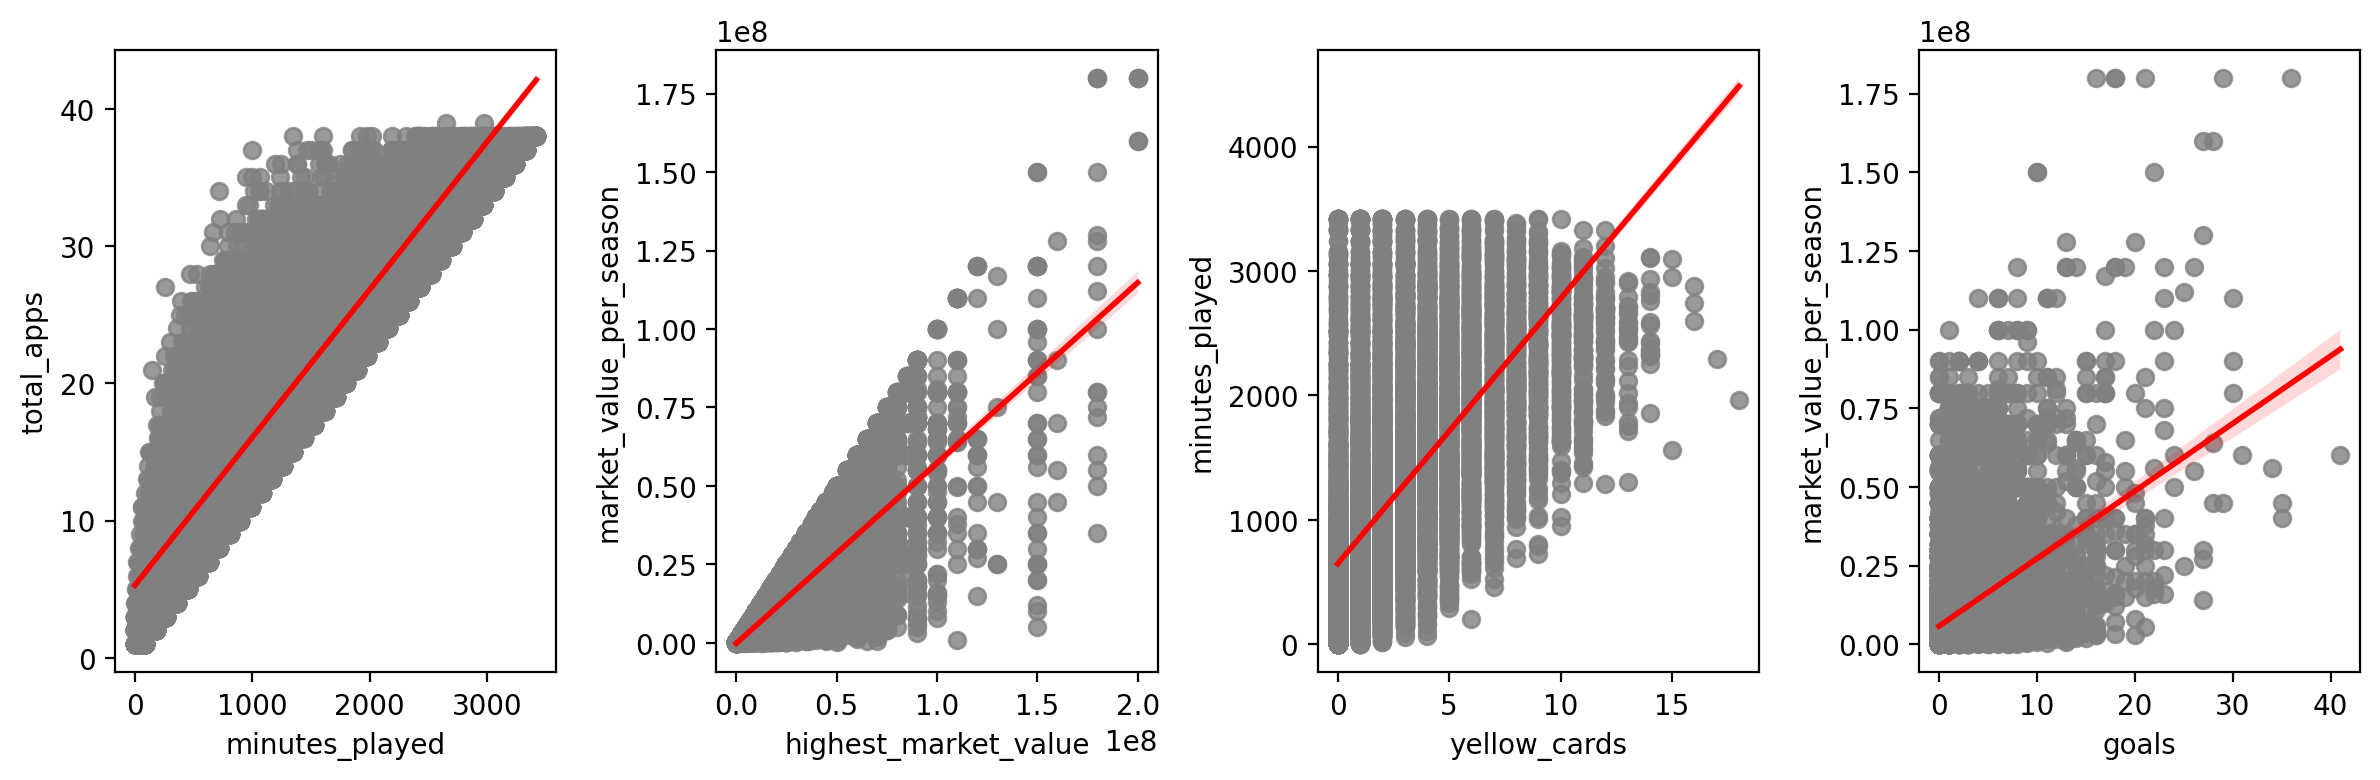

In [207]:
# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

# regplot 그려서 추세선과 상관관계 확인
for key, ax in zip(high_corr, axes):
    sns.regplot(x=df[f"{key}"],
                y=df[high_corr[f"{key}"]],
                ax=ax,
                scatter_kws={"color":"gray"},
                line_kws={"color":"red", "lw":2})

fig.tight_layout()
plt.show()

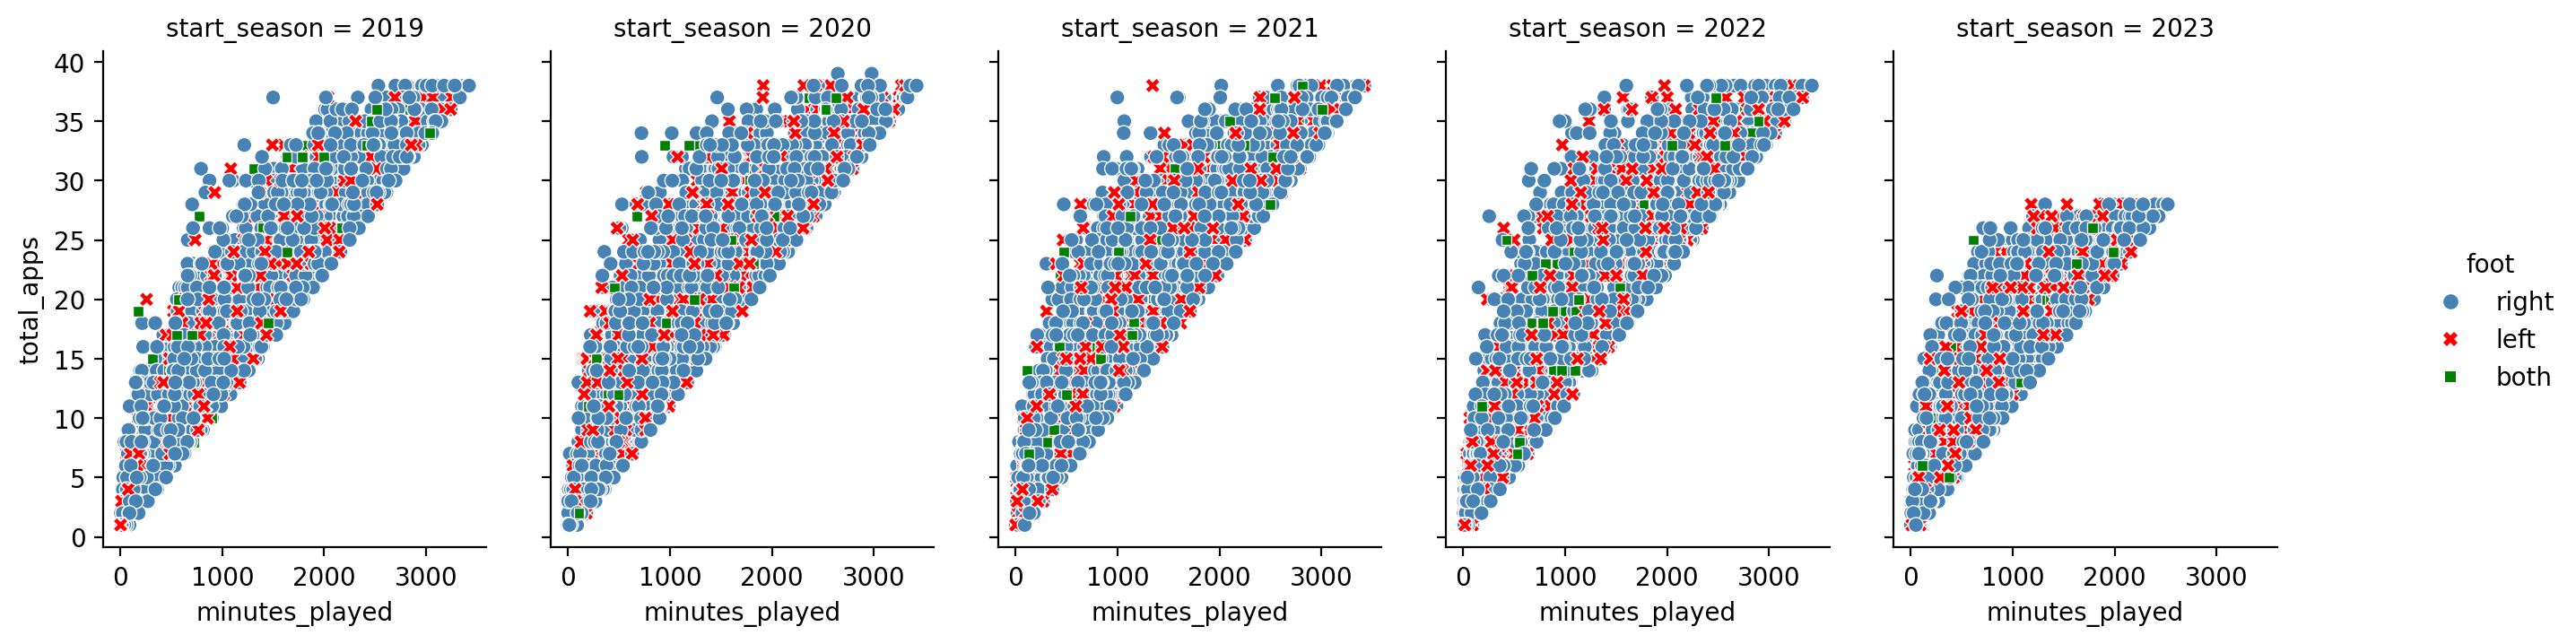

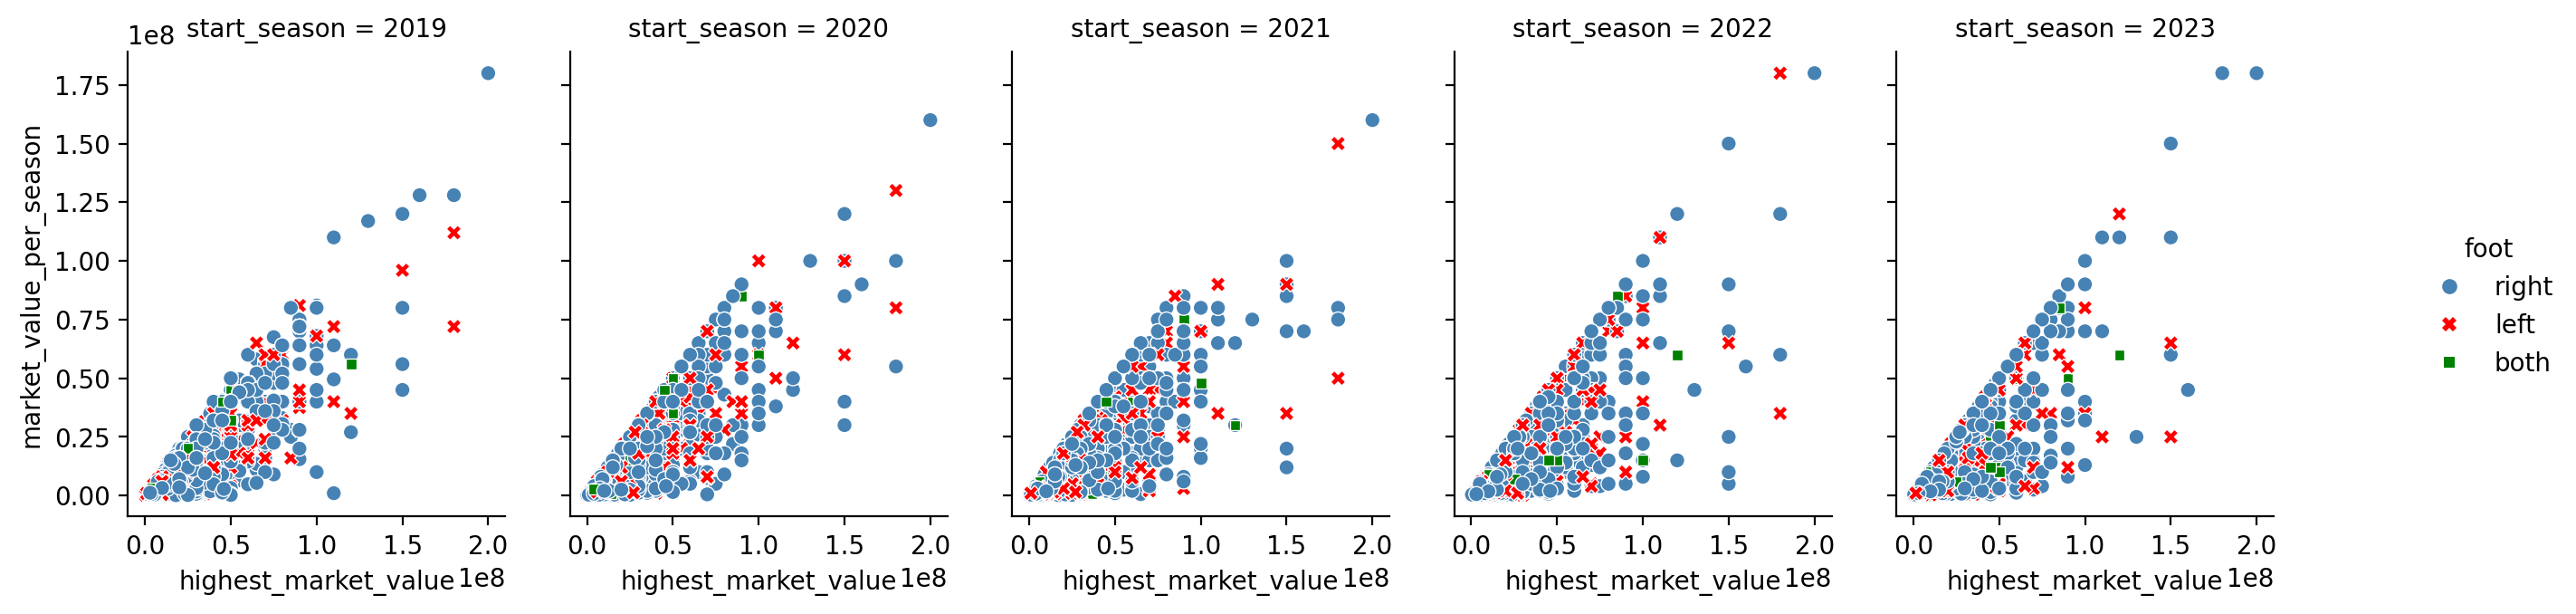

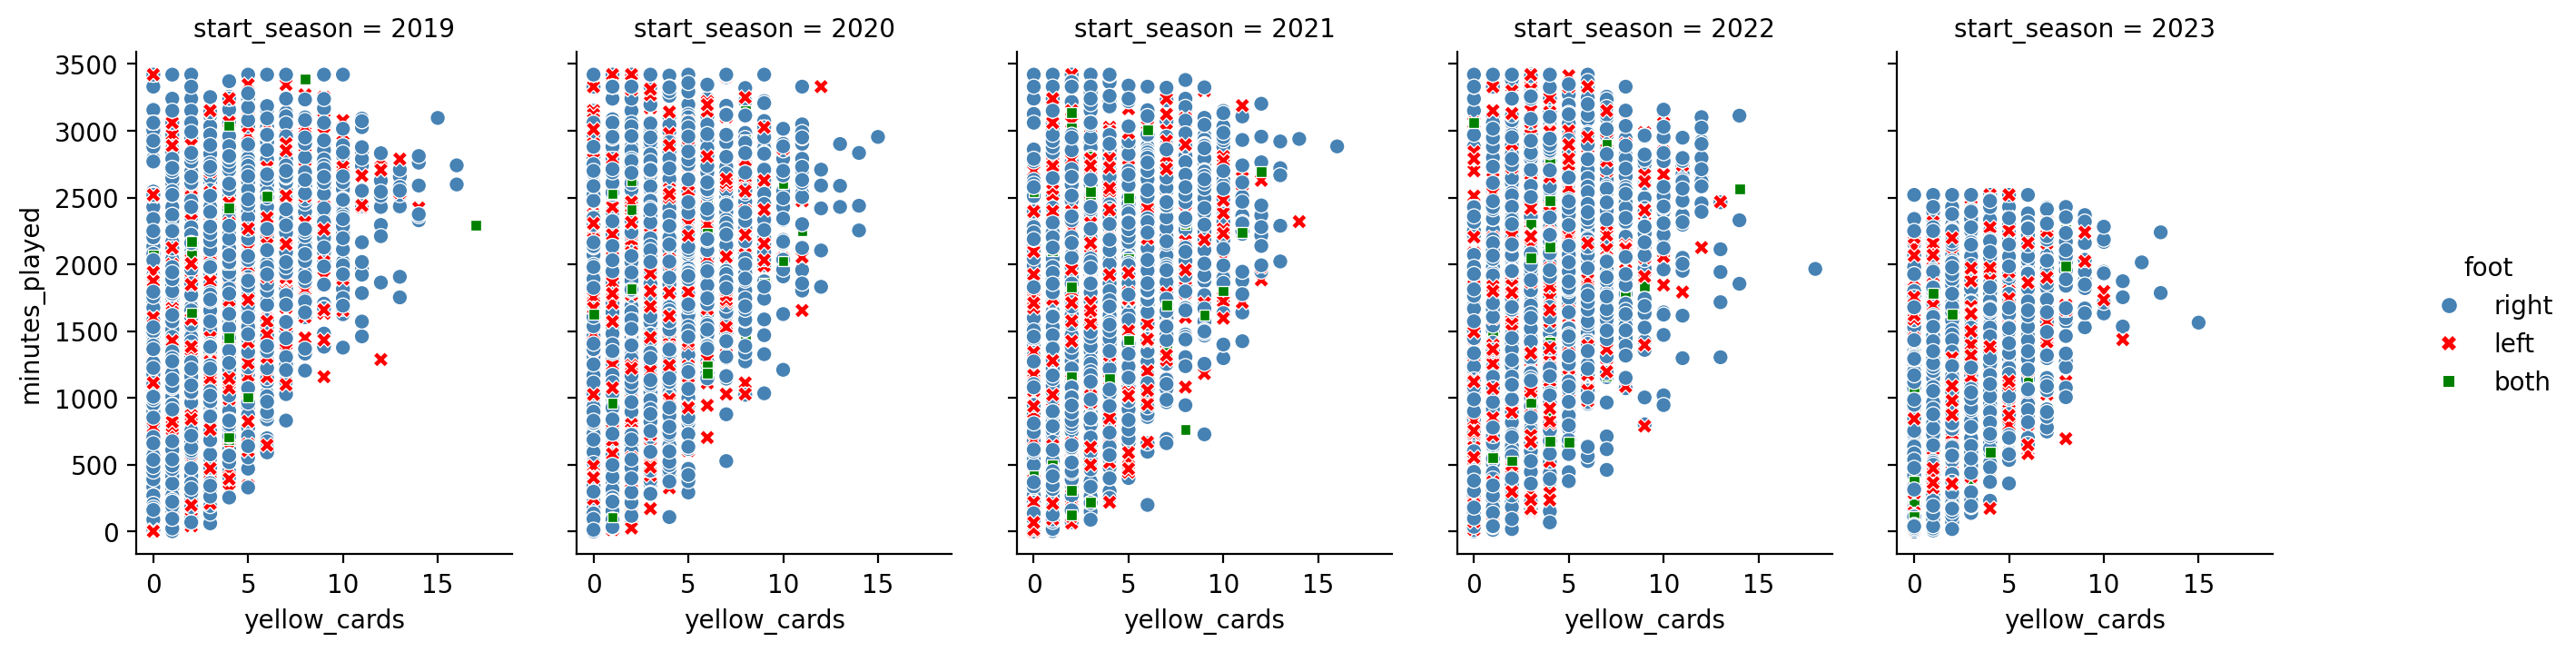

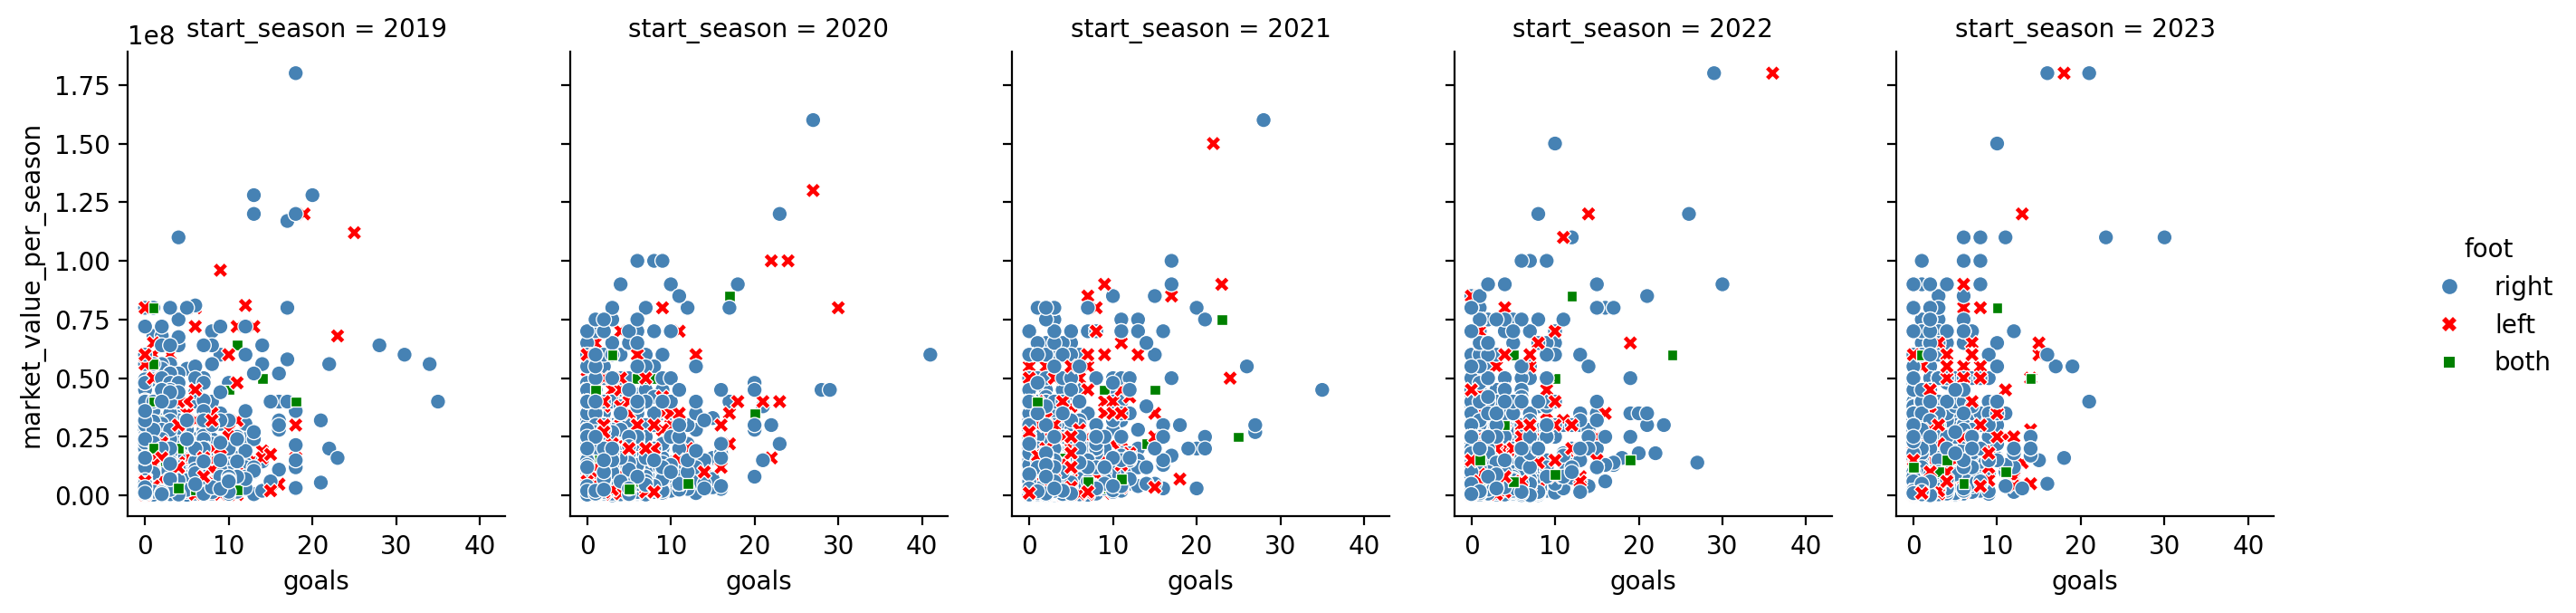

In [208]:
# sns.relplot 통해 상관계수 높은 컬럼들이 start_season에 따라 어떻게 분포가 달라지는지 확인
# 전체적으로 비슷한 모습 보인다

g1 = sns.relplot(data=df,
                 x="minutes_played",
                 y="total_apps",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g2 = sns.relplot(data=df,
                 x="highest_market_value",
                 y="market_value_per_season",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g3 = sns.relplot(data=df,
                 x="yellow_cards",
                 y="minutes_played",
                 col="start_season",
                 hue="foot",
                 style="foot", height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g4 = sns.relplot(data=df,
                 x="goals",
                 y="market_value_per_season",
                 col="start_season",
                 hue="foot",
                 style="foot",height=3, aspect=.5,
                 palette=["steelblue", "r", "g"])

g1.fig.set_size_inches(15, 4)
g2.fig.set_size_inches(15, 4)
g3.fig.set_size_inches(15, 4)
g4.fig.set_size_inches(15, 4)

## 다중 공선성
- 하나의 독립 변수가 여러개의 독립 변수들로 잘 예측되는 경우를 의미한다
- 독립 변수들이 서로 독립이 아니라, 상호 상관관계가 강한 경우 발생
- 일반적으로 어떤 독립 변수의 영향력을 파악할 때, 확인하려는 변수의 영향력만을 판단하기 위해 다른 독립 변수들은 모두 일정하다고 가정한다.
- 그러나 만약 두 독립 변수가 서로에게 영향을 주고 있다면, 하나의 영향력을 검증할 때 다른 하나의 영향력을 완전히 통제할 수 없게 된다
    - 이러한 상황에서는 도출된 해석이 타당하다고 볼 수 없다
    
- 다중 공선성이 존재한다면 모델 구축 시 발생하는 상황
    - 계수 추정이 잘 되지 않거나, 불안정해져서 데이터가 약간만 바뀌어도 추정치 크게 달라짐
    - 계수가 통계적으로 유의미하지 않은 것처럼 도출
    - 과적합의 위험성
    - 특히 회귀 분석에 큰 영향 미친다 (분류는 영향 크게 미칠때도 있고 별로 상관 없을 때도 있음)
- References
    - https://dacon.io/codeshare/4443
    - https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
    - https://dacon.io/forum/408387

### 다중 공선성 진단
- 분산팽창계수 (VIF, Variance Inflation Factor)를 구한다
- 일반적으로 5 또는 10보다 크면 다중 공선성이 있다고 판단한다

- VIF : 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 지표
    - 다른 변수에 의존적일 수록 VIF가 증가

In [209]:
# 출처 : https://aliencoder.tistory.com/17

def feature_engineering_XbyVIF(df):
    vif = pd.DataFrame()

    # df의 컬럼 개수만큼 variance_inflation_factor를 구한다
    vif['VIF_Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    # df의 컬럼 이름을 vif의 Feature 열에 넣어준다
    vif['Feature'] = df.columns
    return vif

vif = feature_engineering_XbyVIF(df[num_cols])
print(vif)

   VIF_Factor                  Feature
0  866.463786             start_season
1    3.312584             yellow_cards
2    1.090990                red_cards
3    2.141445                    goals
4    2.501639                  assists
5   19.924435           minutes_played
6   28.072209               total_apps
7    5.579051     highest_market_value
8    5.258053  market_value_per_season
9  854.251909             height_in_cm


### 다중 공선성 해결 방법
- 다중 공선성을 갖는 독립 변수 중 하나 혹은 일부를 제거한다
    - 단 회귀 모형의 R-square 값을 유지 또는 개선시키는 방향으로만 수행해야 한다
- 변수를 변형시키거나 새로운 관측치를 이용한다
- 자료를 수집하는 현장의 상황을 보아 상관관계의 이유를 파악하여 해결한다
- 주성분 분석 (Principle Component Analysis, PCA)을 이용한 diagonal matrix의 형태로 공선성을 없애준다

- References
    - https://aliencoder.tistory.com/17

#### 다중 공선성 결론
- 회귀 모델을 생성할 때, 높은 VIF 수치를 보이는 `minutes_played` - `total_apps` (상관계수 0.92) 컬럼을 지우거나 변형, 개선한다

In [210]:
num_cols

['start_season',
 'yellow_cards',
 'red_cards',
 'goals',
 'assists',
 'minutes_played',
 'total_apps',
 'highest_market_value',
 'market_value_per_season',
 'height_in_cm']

In [211]:
# 수치형 변수 num_cols에서, 높은 VIF 수치를 보이는 total_apps 제거한 후 VIF 확인
df_no_apps = df.drop("total_apps", axis="columns")
feature_engineering_XbyVIF(df_no_apps[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 
                                       'highest_market_value','market_value_per_season', 'height_in_cm']])

VIF_Factor                  Feature
0    3.245690             yellow_cards
1    1.090868                red_cards
2    2.087224                    goals
3    2.313207                  assists
4    5.586531           minutes_played
5    5.562560     highest_market_value
6    5.197108  market_value_per_season
7    3.046145             height_in_cm

In [212]:
# 수치형 변수 num_cols에서, 높은 VIF 수치를 보이는 total_apps, highest_market_value 제거한 후 VIF 확인
# → market_value_per_season 수치 감소 (약 5.2 → 1.9)
feature_engineering_XbyVIF(df_no_apps[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 
                                       'market_value_per_season', 'height_in_cm']])

VIF_Factor                  Feature
0    3.244463             yellow_cards
1    1.090841                red_cards
2    2.080904                    goals
3    2.304406                  assists
4    5.581710           minutes_played
5    1.919663  market_value_per_season
6    2.834538             height_in_cm

In [213]:
# total_apps, highest_market_value 제거한 데이터프레임을 df에 선언
# → 다중 공선성 해결
df = df.drop(["total_apps", "highest_market_value"], axis=1)
df.head(3)

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0  Aaron Connolly          2019             0          0      3        2   
1  Aaron Connolly          2020             0          0      2        1   
2  Aaron Connolly          2021             0          0      0        0   

   minutes_played competition_code date_of_birth        position  \
0            1261   premier-league    2000-01-28  Centre-Forward   
1             791   premier-league    2000-01-28  Centre-Forward   
2             155   premier-league    2000-01-28  Centre-Forward   

                        current_club_name  market_value_per_season  country  \
0  Brighton and Hove Albion Football Club                4000000.0  Ireland   
1  Brighton and Hove Albion Football Club                7000000.0  Ireland   
2  Brighton and Hove Albion Football Club                6000000.0  Ireland   

    foot  height_in_cm  
0  right         174.0  
1  right         174.0  
2  right         174.0

## `column`별 분석

### `goals`, `assists` 분석

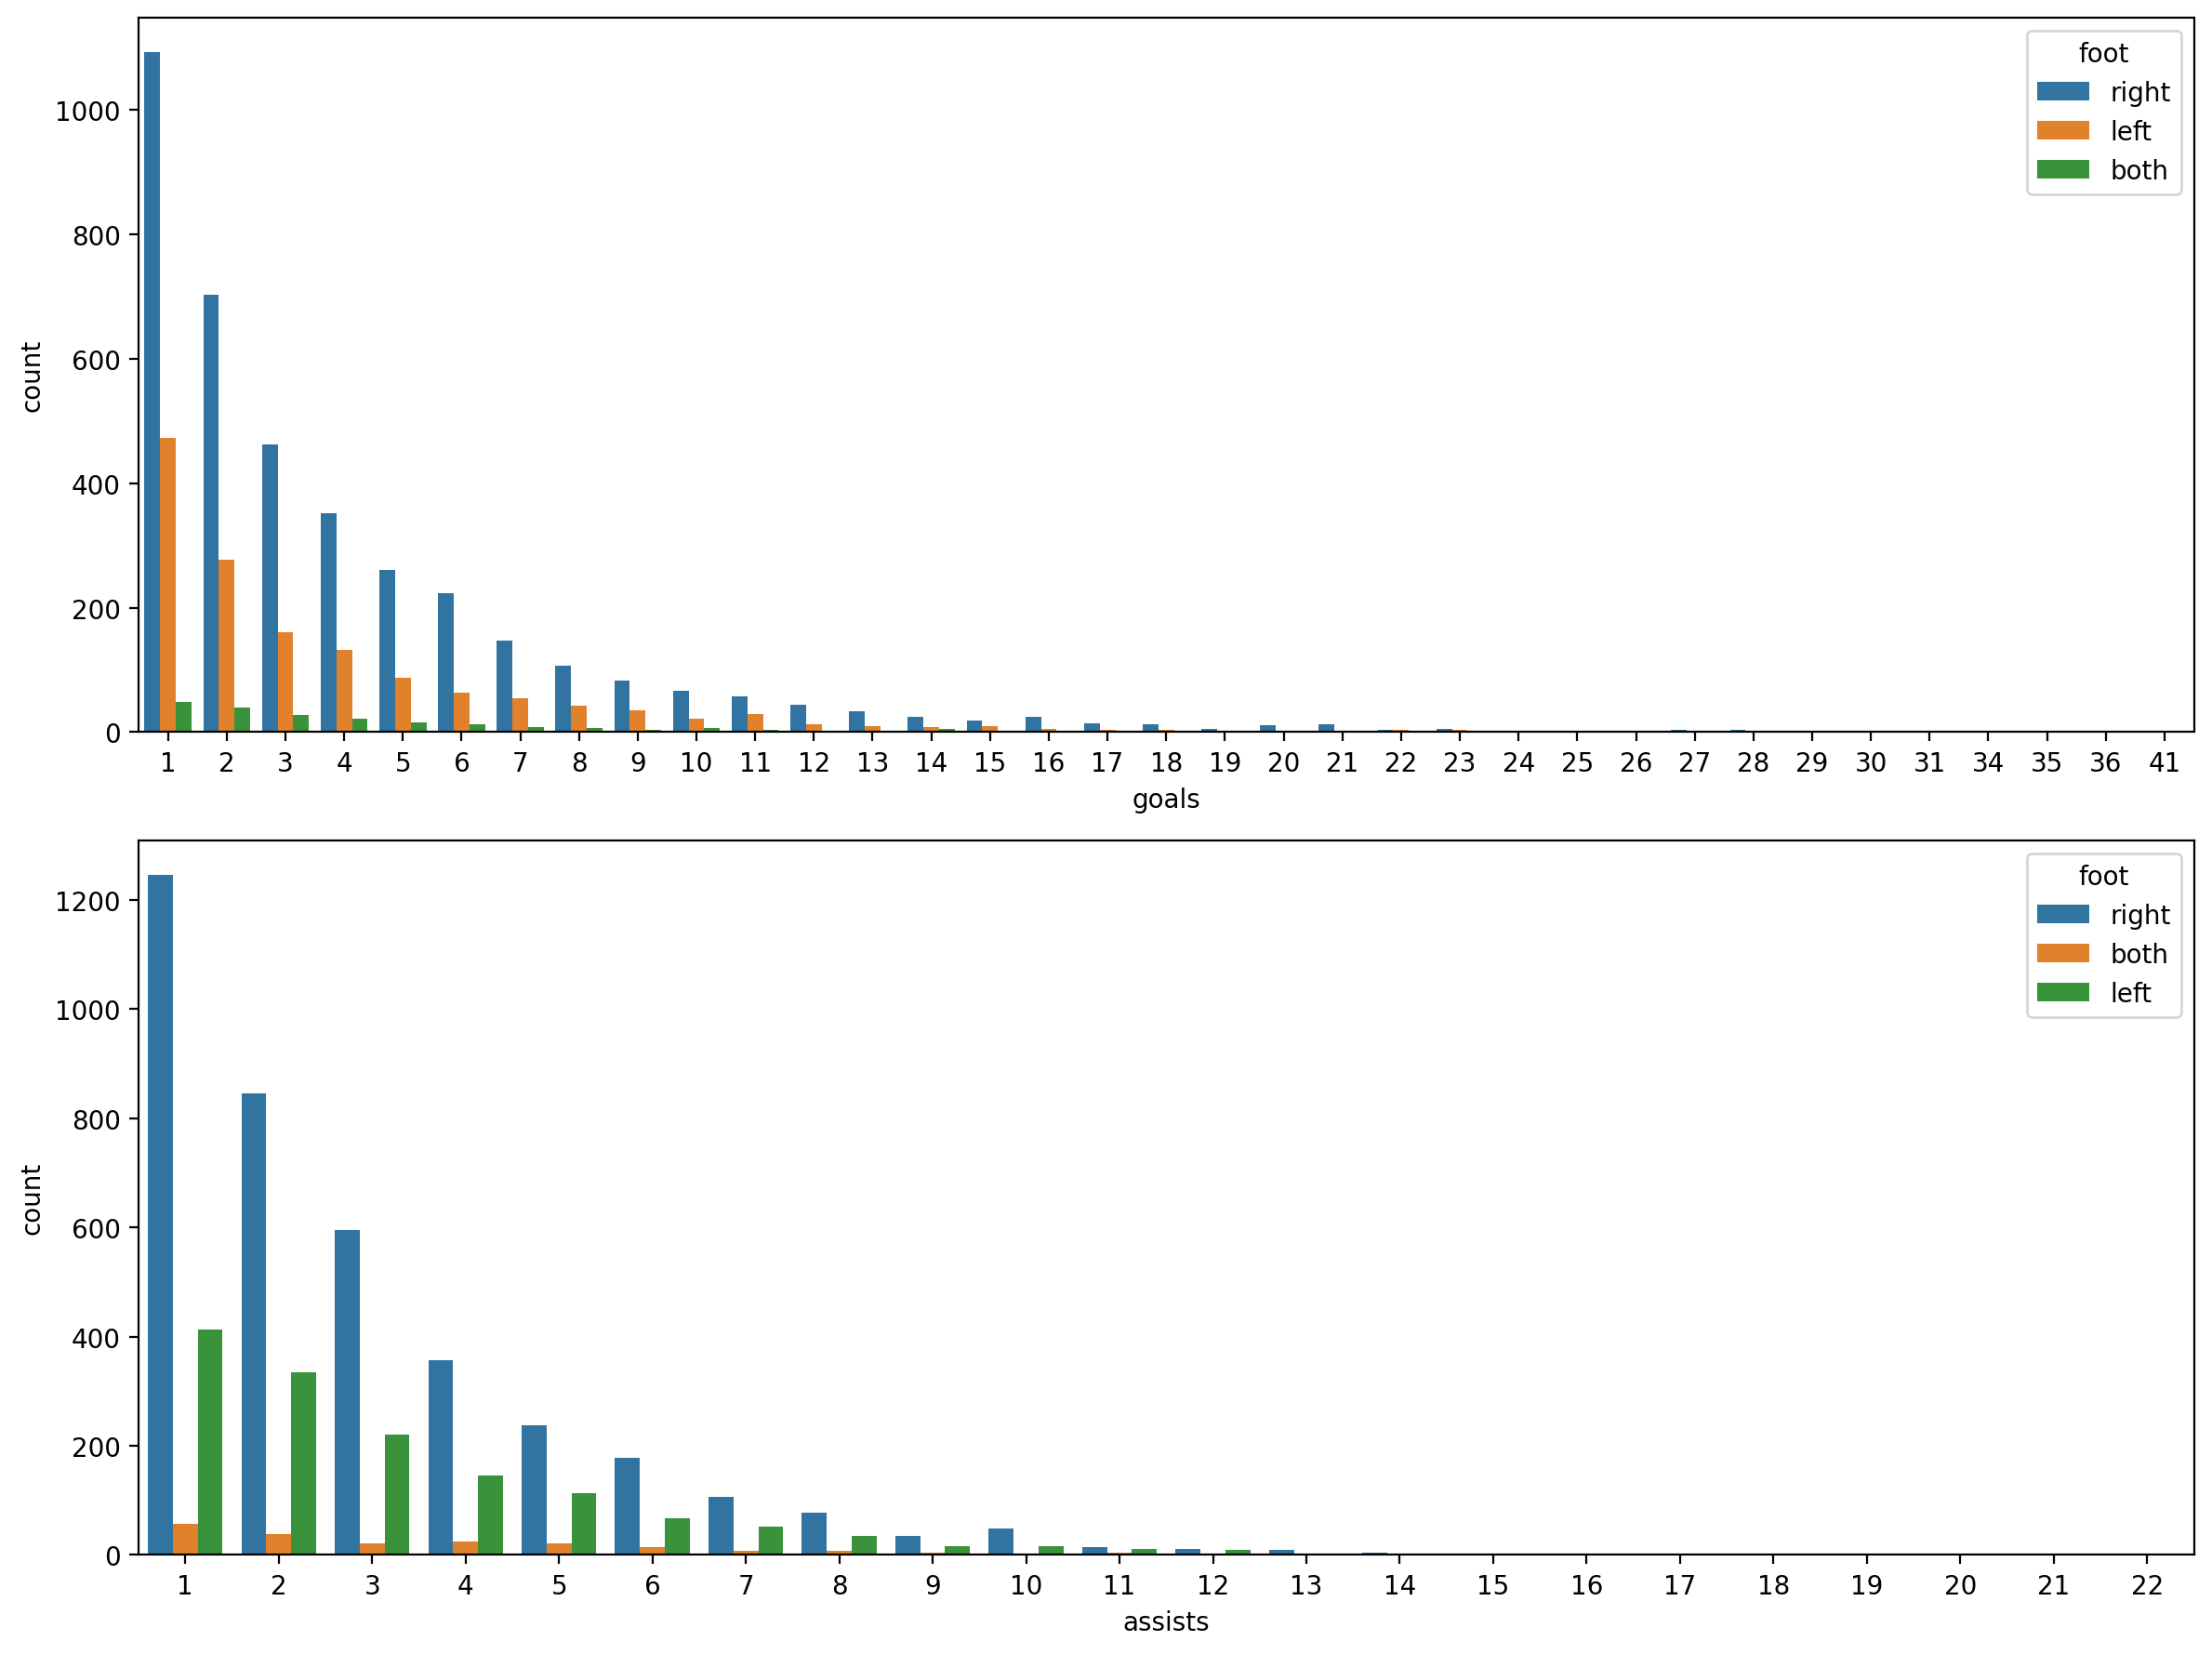

In [214]:
goals_assists = ["goals", "assists"]
more_than_zero = (df.goals>0) & (df.assists>0)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

for col, ax in zip(goals_assists, axes):
    sns.countplot(data=df[more_than_zero], x=col, ax=ax, hue="foot")

fig.tight_layout()

plt.show()

In [215]:
# 41 득점한 선수 확인
df[df.goals==41]

player_name  start_season  yellow_cards  red_cards  goals  \
12858  Robert Lewandowski          2020             4          0     41   

       assists  minutes_played competition_code date_of_birth        position  \
12858        7            2463       bundesliga    1988-08-21  Centre-Forward   

           current_club_name  market_value_per_season country   foot  \
12858  Futbol Club Barcelona               60000000.0  Poland  right   

       height_in_cm  
12858         185.0

In [216]:
# 22 어시스트한 선수 확인
df[df.assists==22]

player_name  start_season  yellow_cards  red_cards  goals  assists  \
8652  Lionel Messi          2019             4          0     25       22   

      minutes_played competition_code date_of_birth      position  \
8652            2880           laliga    1987-06-24  Right Winger   

                      current_club_name  market_value_per_season    country  \
8652  Paris Saint-Germain Football Club              112000000.0  Argentina   

      foot  height_in_cm  
8652  left         170.0

#### 시즌별 Goals, Assists Top 10 확인

In [217]:
func1 = lambda g: g.sort_values(by="goals", ascending=False)[:10]
func2 = lambda g: g.sort_values(by="assists", ascending=False)[:10]

In [218]:
goal_top10 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_top10.head()

player_name  goals  assists
start_season                                          
2019         2681        Ciro Immobile     35        8
             12857  Robert Lewandowski     34        4
             2836    Cristiano Ronaldo     31        6
             14657         Timo Werner     28        8
             8652         Lionel Messi     25       22

In [219]:
assist_top10 = df.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_top10.head()

player_name  goals  assists
start_season                                       
2019         8652      Lionel Messi     25       22
             14530    Thomas Müller      8       21
             8066   Kevin De Bruyne     13       20
             6319      Jadon Sancho     17       17
             9003      Luis Alberto      6       16

In [220]:
goals_assists_top10 = pd.concat([goal_top10, assist_top10]).reset_index()
goals_assists_top10.head()

start_season  level_1         player_name  goals  assists
0          2019     2681       Ciro Immobile     35        8
1          2019    12857  Robert Lewandowski     34        4
2          2019     2836   Cristiano Ronaldo     31        6
3          2019    14657         Timo Werner     28        8
4          2019     8652        Lionel Messi     25       22

##### 시각화 (`plotly`)

In [236]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_top10, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season")
# fig.update_traces(textposition="top right")
fig.show()

#### 5경기 이상 뛴 선수들로 시즌별 Goals, Assists Top 10 확인

In [222]:
df_over_5_games = df[df.minutes_played>=450]
df_over_5_games.head()

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0   Aaron Connolly          2019             0          0      3        2   
1   Aaron Connolly          2020             0          0      2        1   
3  Aaron Cresswell          2019             7          0      3        0   
4  Aaron Cresswell          2020             3          0      0        8   
5  Aaron Cresswell          2021             3          0      2        3   

   minutes_played competition_code date_of_birth        position  \
0            1261   premier-league    2000-01-28  Centre-Forward   
1             791   premier-league    2000-01-28  Centre-Forward   
3            2730   premier-league    1989-12-15       Left-Back   
4            3172   premier-league    1989-12-15       Left-Back   
5            2728   premier-league    1989-12-15       Left-Back   

                        current_club_name  market_value_per_season  country  \
0  Brighton and Hove Albion Football Club                4000000.0  Ireland   
1  Brighton and Hove Albion Football Club                7000000.0  Ireland   
3           West Ham United Football Club                6500000.0  England   
4           West Ham United Football Club                5000000.0  England   
5           West Ham United Football Club                3000000.0  England   

    foot  height_in_cm  
0  right         174.0  
1  right         174.0  
3   left         170.0  
4   left         170.0  
5   left         170.0

In [223]:
goal_5_games_top10 = df_over_5_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_5_games_top10.head()

player_name  goals  assists
start_season                                          
2019         2681        Ciro Immobile     35        8
             12857  Robert Lewandowski     34        4
             2836    Cristiano Ronaldo     31        6
             14657         Timo Werner     28        8
             8652         Lionel Messi     25       22

In [224]:
assist_5_games_top10 = df_over_5_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_5_games_top10.head()

player_name  goals  assists
start_season                                       
2019         8652      Lionel Messi     25       22
             14530    Thomas Müller      8       21
             8066   Kevin De Bruyne     13       20
             6319      Jadon Sancho     17       17
             11808       Papu Gómez      7       16

In [225]:
goals_assists_5_games_top10 = pd.concat([goal_5_games_top10, assist_5_games_top10]).reset_index()
goals_assists_5_games_top10.head()

start_season  level_1         player_name  goals  assists
0          2019     2681       Ciro Immobile     35        8
1          2019    12857  Robert Lewandowski     34        4
2          2019     2836   Cristiano Ronaldo     31        6
3          2019    14657         Timo Werner     28        8
4          2019     8652        Lionel Messi     25       22

##### 시각화 (plotly)

In [237]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_5_games_top10, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season",
                 width=1200, height=2000)

# fig.update_traces(textposition="top right")
fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")


# fig.data[0].text = [e if e >= 25 else '' for e in goals_assists_5_games_top10["goals"]]

# goals_assists_5_games_top10_2 = goals_assists_5_games_top10[goals_assists_5_games_top10.goals >= 25]

# fig.add_annotation(x=np.log10(goals_assists_5_games_top10_2['goals']).iloc[0],
#                    y=goals_assists_5_games_top10_2["assists"].iloc[0],
#                    text = goals_assists_5_games_top10_2["player_name"].iloc[0],
#                    showarrow = True,
#                    ax = 10,
#                    ay = -25)

fig.show()

In [227]:
df_over_5_games.columns

Index(['player_name', 'start_season', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'competition_code', 'date_of_birth',
       'position', 'current_club_name', 'market_value_per_season', 'country',
       'foot', 'height_in_cm'],
      dtype='object')

### `market_value_per_season` 분석

In [228]:
fig = px.histogram(data_frame=df, x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay',  title_text="Market Value per Season")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 20M 넘는 선수들로 확인

In [229]:
print("원본 df shape :", df.shape)
print("20M 유로 넘는 선수들 :", df[df.market_value_per_season >= 20000000].shape)

원본 df shape : (16001, 15)
20M 유로 넘는 선수들 : (2288, 15)


In [230]:
fig = px.histogram(data_frame=df[df.market_value_per_season >= 20000000], x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay', title_text="Market Value per Season more than 1M Euros")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

##### 100M 유로 넘는 선수들 확인

In [238]:
df[df.market_value_per_season>=100000000].head(3)

player_name  start_season  yellow_cards  red_cards  goals  assists  \
2209  Bukayo Saka          2022             6          0     14       11   
2210  Bukayo Saka          2023             3          0     13       10   
3363  Declan Rice          2023             3          0      6        6   

      minutes_played competition_code date_of_birth            position  \
2209            3194   premier-league    2001-09-05        Right Winger   
2210            2274   premier-league    2001-09-05        Right Winger   
3363            2398   premier-league    1999-01-14  Defensive Midfield   

          current_club_name  market_value_per_season  country   foot  \
2209  Arsenal Football Club              120000000.0  England   left   
2210  Arsenal Football Club              120000000.0  England   left   
3363  Arsenal Football Club              110000000.0  England  right   

      height_in_cm  
2209         178.0  
2210         178.0  
3363         188.0

In [232]:
# 시장가치 100M 유로 넘는 선수들 확인

# 시장가치 100M 유로 넘는 선수들 중, player_name으로 groupby한 선수들의 market_value_per_season 최대값 중복해서 조회
mm = df[df.market_value_per_season>=100000000]
more_than_100 = mm.groupby("player_name", as_index=False).market_value_per_season.max().merge(mm)

# 득점, 어시스트 합산해서 공격포인트 (g+a) 컬럼 생성
more_than_100["g+a"] = more_than_100["goals"] + more_than_100["assists"]
more_than_100.sort_values("start_season", ascending=False).head(15)

player_name  market_value_per_season  start_season  yellow_cards  \
17      Kylian Mbappé              180000000.0          2023             3   
12      Jamal Musiala              110000000.0          2023             2   
28            Rodrygo              100000000.0          2023             2   
26              Rodri              110000000.0          2023             8   
24         Phil Foden              110000000.0          2023             1   
18   Lautaro Martínez              110000000.0          2023             3   
1         Bukayo Saka              120000000.0          2023             3   
13    Jude Bellingham              180000000.0          2023             5   
34    Vinicius Junior              150000000.0          2023             4   
7       Florian Wirtz              100000000.0          2023             3   
2         Declan Rice              110000000.0          2023             3   
6   Federico Valverde              100000000.0          2023             2   
4      Erling Haaland              180000000.0          2023             1   
22              Pedri              100000000.0          2022             2   
23         Phil Foden              110000000.0          2022             1   

    red_cards  goals  assists  minutes_played competition_code date_of_birth  \
17          0     21        4            1756          ligue-1    1998-12-20   
12          0      8        5            1498       bundesliga    2003-02-26   
28          0      8        5            1944           laliga    2001-01-09   
26          1      6        6            2170   premier-league    1996-06-22   
24          0     11        7            2316   premier-league    2000-05-28   
18          0     23        4            2035          serie-a    1997-08-22   
1           0     13       10            2274   premier-league    2001-09-05   
13          1     16        3            1876           laliga    2003-06-29   
34          0     10        5            1462           laliga    2000-07-12   
7           0      6       10            2006       bundesliga    2003-05-03   
2           0      6        6            2398   premier-league    1999-01-14   
6           0      1        4            2296           laliga    1998-07-22   
4           0     18        5            1925   premier-league    2000-07-21   
22          0      6        1            1982           laliga    2002-11-25   
23          0     11        5            1842   premier-league    2000-05-28   

              position                           current_club_name    country  \
17      Centre-Forward           Paris Saint-Germain Football Club     France   
12  Attacking Midfield                           FC Bayern München    Germany   
28        Right Winger                  Real Madrid Club de Fútbol     Brazil   
26  Defensive Midfield               Manchester City Football Club      Spain   
24        Right Winger               Manchester City Football Club    England   
18      Centre-Forward  Football Club Internazionale Milano S.p.A.  Argentina   
1         Right Winger                       Arsenal Football Club    England   
13  Attacking Midfield                  Real Madrid Club de Fútbol    England   
34         Left Winger                  Real Madrid Club de Fútbol     Brazil   
7   Attacking Midfield                 Bayer 04 Leverkusen Fußball    Germany   
2   Defensive Midfield                       Arsenal Football Club    England   
6     Central Midfield                  Real Madrid Club de Fútbol    Uruguay   
4       Centre-Forward               Manchester City Football Club     Norway   
22    Central Midfield                       Futbol Club Barcelona      Spain   
23        Right Winger               Manchester City Football Club    England   

     foot  height_in_cm  g+a  
17  right         178.0   25  
12  right         184.0   13  
28  right         174.0   13  
26  right         191.0   12  
24   left         171.0   18

In [233]:
more_than_100.shape

(35, 16)

###### Goals, Assists 시각화

In [234]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top right")
fig.show()

###### 공격포인트 합산 시각화

In [235]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100.sort_values("start_season"), x="market_value_per_season", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                 text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 Games")
fig.update_traces(textposition="top center")
fig.show()